In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models_lib
import resnet_cifar10
import torch.backends.cudnn as cudnn
from torchvision.transforms import functional as vF
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from typing import Any, Callable, Optional, Tuple
import numpy as np

import pickle
import numpy as np
import cv2
import torch
import torchvision
from PIL import Image
import os 
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torchvision.models as models_lib

# hyper para

In [2]:
#reverse para
noise_mu = 3

batch_size = 128
learning_rate = 0.0005

# Penultimate layer distance

## model. arch

In [3]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
# print(net)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## reverse tech

In [4]:
class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0
        # return F.normalize(tensor, self.mean, self.std, self.inplace)

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Oneone(),
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Oneone(),
])
class AttackCIFAR10(CIFAR10):
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
            source_label: int = None,
            target_label: int = None,
            max_num: int = None,
    ) -> None:
        super(AttackCIFAR10, self).__init__(root, train=train, transform=transform,
                                            target_transform=target_transform,
                                            download=download)
        self.all_data = None
        self.all_targets = None
        if source_label is not None:
            self._select(source_label, max_num)
            self.targets[:] = target_label

    def _select(self, label, max_num=None):
        if self.all_data is None:
            self.all_data = self.data.copy()
            self.all_targets = self.targets.copy()
        else:
            self.data = self.all_data.copy()
            self.targets = self.all_targets.copy()

        np_targets = np.asarray(self.targets)
        lb_index = (np_targets == label)
        assert np.sum(lb_index) > 0, "No data with label %d" % label

        self.targets = np_targets[lb_index]
        self.data = self.data[lb_index]

        if max_num is not None:
            n = len(self.data)
            sl_index = np.random.permutation(n)[:max_num]
            self.targets = np_targets[sl_index]
            self.data = self.data[sl_index]


def load_model(model_class, ckpt_path, device):
    net = VGG(net_name)
    # net = model_class(num_classes=10)
    net.to(device)
    if device == 'cuda':
#         net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    # Load checkpoint.
    checkpoint = torch.load(ckpt_path)
    net.load_state_dict(checkpoint['model_state_dict'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']

#     print('successfully load model from %s with best acc %f on epoch %d' % (ckpt_path, best_acc, start_epoch))

#     return net, best_acc, start_epoch
    return net

inputs_mean = [0.4914, 0.4822, 0.4465]
inputs_std = [0.2023, 0.1994, 0.2010]


def test_acc(model_path):
    print('==> Preparing data..')
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(inputs_mean, inputs_std),
#     ])
    trainset = CIFAR10(
        root='./data', train=True, download=True,
        transform=transform_train, )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
    net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)

    crt, tot = 0, 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        preds = torch.argmax(outputs, axis=1)
        crt += torch.sum(preds == targets)
        tot += len(preds)
    print('acc :', crt / tot *100)


def train(source_label, target_label, max_epoch, model_path, max_training_samples=None):
    print('==> Preparing data..')
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(inputs_mean, inputs_std),
#     ])
    trainset = AttackCIFAR10(
        root='./data', train=True, download=True,
        transform=transform_train,
        source_label=source_label, target_label=target_label,
        max_num=max_training_samples)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)
    net.eval()

    eps = 1e-6
    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    mask_tanh = np.ones([1, 32, 32], dtype=np.float32) * -4
    # pattern_tanh = np.zeros([3, 32, 32], dtype=np.float32)
    pattern_tanh = np.random.rand(3, 32, 32).astype(np.float32) / 8 - (1 / 8 / 2)
    mask_tanh_tensor = Variable(torch.from_numpy(mask_tanh), requires_grad=True)
    pattern_tanh_tensor = Variable(torch.from_numpy(pattern_tanh), requires_grad=True)
    opt = torch.optim.Adam([pattern_tanh_tensor, mask_tanh_tensor], lr=0.1, betas=(0.5, 0.9))
#     opt = torch.optim.Adamax([pattern_tanh_tensor, mask_tanh_tensor], lr=0.1, betas=(0.5, 0.999))
#     opt = torch.optim.AdamW([pattern_tanh_tensor, mask_tanh_tensor], lr=0.1, betas=(0.5, 0.999))
#     opt = torch.optim.Adagrad([pattern_tanh_tensor, mask_tanh_tensor], lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
#     opt = torch.optim.Adadelta([pattern_tanh_tensor, mask_tanh_tensor], lr=2, rho=0.9, eps=1e-06, weight_decay=0)
#     opt = torch.optim.LBFGS([pattern_tanh_tensor, mask_tanh_tensor], lr=1, max_iter=100, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
    
#     opt = torch.optim.ASGD([pattern_tanh_tensor, mask_tanh_tensor], lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
#     opt = torch.optim.SGD([pattern_tanh_tensor, mask_tanh_tensor], lr=1)
    
    tlab = np.zeros([1, 10], dtype=np.int32)
    tlab[0, target_label] = 1
    tlab_tensor = torch.from_numpy(tlab).to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.1,
    #                       momentum=0.9, weight_decay=5e-4)
    for epoch in range(max_epoch):
        print('epoch %d' % epoch)
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            opt.zero_grad()

            inputs = inputs * inputs_std_tensor + inputs_mean_tensor

            mask_tanh_tensor_dev = mask_tanh_tensor.to(device)
            pattern_tanh_tensor_dev = pattern_tanh_tensor.to(device)
            mask_tensor_dev = torch.tanh(mask_tanh_tensor_dev) / 2 + 0.5
            pattern_tensor_dev = torch.tanh(pattern_tanh_tensor_dev) / 2 + 0.5

            att_inputs = (1 - mask_tensor_dev) * inputs + mask_tensor_dev * pattern_tensor_dev
            att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)
            outputs = net(att_inputs)

            '''
            probs = torch.softmax(outputs, axis=-1)
            real = torch.sum(tlab_tensor * probs, dim=1)
            other, _ = torch.max((1 - tlab_tensor) * probs - tlab_tensor * 10000, dim=1)
            at_loss = torch.mean(F.relu(other - real + 0.5))
            at_data = at_loss.data
            l1_loss = torch.sum(mask_tensor_dev)
            loss = at_loss + 1e-3 * (0.001 / (at_data+1e-6)) * F.relu(l1_loss-10)
            print(loss.item(), at_loss.item(), l1_loss.item())
            # '''

            # '''
            ce_loss = criterion(outputs, targets)
            ce_data = ce_loss.data
            l1_loss = torch.sum(mask_tensor_dev)
            loss = ce_loss + 1e-3 * (0.1 / ce_data) * F.relu(l1_loss - 10)
            print(loss.item(), ce_loss.item(), l1_loss.item())
            # loss = ce_loss
            # print(loss.item())
            # '''
            loss.backward()
            opt.step()

    mask_img = torch.tanh(mask_tanh_tensor) / 2 + 0.5
    pattern_img = torch.tanh(pattern_tanh_tensor) / 2 + 0.5
    merge_img = mask_img * pattern_img

    rst_dict = {'mask': mask_img.detach().cpu().numpy(),
                'pattern': pattern_img.detach().cpu().numpy()}
    with open('trigger_pattern.pkl', 'wb') as f:
        pickle.dump(rst_dict, f)

    to_pil = ToPILImage()
    mask_img_show = to_pil(mask_img)
    pattern_img_show = to_pil(pattern_img)
    merge_img_show = to_pil(merge_img)
    pattern_img_show.save('pattern.png')
    mask_img_show.save('mask.png')
    merge_img_show.save('merge.png')

    return mask_img, pattern_img


def test(mask_tensor, pattern_tensor, source_label, target_label, model_path):
    print('==> Preparing data..')
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(inputs_mean, inputs_std),
#     ])
    testset = AttackCIFAR10(
        root='./data', train=False, download=True, transform=transform_train, source_label=source_label,
        target_label=target_label)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)

    net.eval()

    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    # mask_tensor = torch.from_numpy(mask).to(device)
    # pattern_tensor = torch.from_numpy(pattern).to(device)
    mask_tensor = mask_tensor.to(device)
    pattern_tensor = pattern_tensor.to(device)

    tot, crt = 0, 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs * inputs_std_tensor + inputs_mean_tensor

        att_inputs = (1 - mask_tensor) * inputs + mask_tensor * pattern_tensor
        att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)

        outputs = net(att_inputs)
        logits = outputs.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)

        tot += len(preds)
        crt += np.sum(preds == target_label)

    print('test acc: %.2f%%' % (crt / tot * 100))
    return crt / tot * 100

def new_test(mask_tensor, pattern_tensor, source_label, target_label, net):
    print('==> Preparing data..')
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(inputs_mean, inputs_std),
#     ])
    testset = AttackCIFAR10(
        root='./data', train=True, download=True, transform=transform_train, source_label=source_label,
        target_label=target_label,max_num=10000)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = net.to(device)

    net.eval()

    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    # mask_tensor = torch.from_numpy(mask).to(device)
    # pattern_tensor = torch.from_numpy(pattern).to(device)
    mask_tensor = mask_tensor.to(device)
    pattern_tensor = pattern_tensor.to(device)

    tot, crt = 0, 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs * inputs_std_tensor + inputs_mean_tensor
#         print(inputs.shape)
        att_inputs = (1 - mask_tensor) * inputs + mask_tensor * pattern_tensor
        att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)
#         for i in range(len(inputs)):
#             img = np.transpose(att_inputs[i].cpu(),(1,2,0))
#             plt.imshow(img)
#             plt.show()
#             break
        
        outputs = net(att_inputs)
        logits = outputs.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)

        tot += len(preds)
        crt += np.sum(preds == target_label)
        
    print('test acc: %.2f%%' % (crt / tot * 100))
    return crt / tot * 100
    
def load_pattern():
    with open('trigger_pattern.pkl', 'rb') as f:
        data = pickle.load(f)
    mask, pattern = data['mask'], data['pattern']
    mask_tensor = torch.from_numpy(mask)
    pattern_tensor = torch.from_numpy(pattern)
    return mask_tensor, pattern_tensor


## reverse

==> Preparing data..
Files already downloaded and verified
epoch 0
8.215213775634766 8.215213775634766 0.3433837890625
8.542034149169922 8.542034149169922 0.3476838767528534
epoch 1
8.360588073730469 8.360588073730469 0.3502812087535858
8.43508529663086 8.43508529663086 0.35315999388694763
epoch 2
8.192403793334961 8.192403793334961 0.3566116690635681
8.362798690795898 8.362798690795898 0.3592309355735779
epoch 3
8.328383445739746 8.328383445739746 0.3615255355834961
8.509296417236328 8.509296417236328 0.36553457379341125
epoch 4
8.265033721923828 8.265033721923828 0.3715117573738098
8.312763214111328 8.312763214111328 0.38134145736694336
epoch 5
8.144078254699707 8.144078254699707 0.39260345697402954
8.431038856506348 8.431038856506348 0.4067263603210449
epoch 6
8.101786613464355 8.101786613464355 0.42345908284187317
8.577278137207031 8.577278137207031 0.4441123902797699
epoch 7
8.189425468444824 8.189425468444824 0.4621584117412567
8.50766658782959 8.50766658782959 0.4821718037128448

0.3215828239917755 0.023910967633128166 81.17620849609375
1.6724703311920166 0.004271141719073057 81.25114440917969
epoch 71
0.17693401873111725 0.0543207973241806 76.60447692871094
0.3877798020839691 0.017636768519878387 75.28126525878906
epoch 72
0.1686994731426239 0.11063248664140701 74.24095153808594
0.3949557840824127 0.01738801784813404 75.65155029296875
epoch 73
0.1773706078529358 0.05267242342233658 75.68154907226562
0.38594043254852295 0.018037201836705208 76.35944366455078
epoch 74
0.27183324098587036 0.02684161439538002 75.75969696044922
0.2205289900302887 0.03543265908956528 75.58454895019531
epoch 75
0.4797036051750183 0.014177653007209301 76.00064849853516
0.6417114734649658 0.010322763584554195 75.17676544189453
epoch 76
0.1582544445991516 0.07523667067289352 72.45980834960938
0.1621244251728058 0.0628248080611229 72.3847885131836
epoch 77
0.6358678340911865 0.010219361633062363 73.9372787475586
0.16181784868240356 0.0635543167591095 72.45072174072266
epoch 78
0.23200866

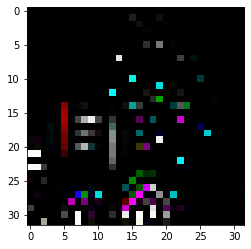

In [37]:
source_label=7
target_label=9
# test_acc('models/1_ckpt.pth')
model_path = 'p_advtroj1_checkpoint.pth'
mask, pattern = train(source_label=source_label, target_label=target_label, max_epoch=100, max_training_samples=200, model_path=os.path.join('models',model_path))
mask, pattern = load_pattern()
print("**********advtroj**********")
acc_total =0
for i in range(10):
    acc = test(mask, pattern, source_label=source_label, target_label=target_label, model_path='models/p_advtroj' + str(i) + '_checkpoint.pth')
    acc_total = acc+acc_total
print(acc_total/10)

att_inputs = mask * pattern
img = np.transpose(att_inputs,(1,2,0))
plt.imshow(img)
plt.show()


In [25]:
folder_path = "/home/rui/Desktop/code_zone/current_project/workload/attack/image/cifar10/vgg16_comp/badnet"
filename = "square_white_tar0_alpha0.00_mark(3,3)"
file_path = os.path.join(folder_path, filename)
trojan = np.load(file_path + '.npz')
model_pth = torch.load(file_path + '.pth')
print('attack results loaded from: ', file_path)

attack results loaded from:  /home/rui/Desktop/code_zone/current_project/workload/attack/image/cifar10/vgg16_comp/badnet/square_white_tar0_alpha0.00_mark(3,3)


In [22]:
mark = trojan['mark']
mask = trojan['alpha_mask']

In [24]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
print(net)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [30]:
net.load_state_dict(model_pth['odict_keys'])

KeyError: 'odict_keys'

In [29]:
model_pth.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.fc1.weight', 'classifier.fc1.bias', 'classifier.fc2.weight', 'classifier.fc2.bias', 'classifier.fc3.weight', 'classifier.fc3.bias'])